## Walking through the steps to calculate the centroid of a single 3D label

First, load the cellpose segmentation file

In [1]:
import numpy as np
import napari

segmenations_path = './220624_Fix_Flvw_Emb_PI_Utr647_E02-10X-Z01_downsample_log_seg-cyto.npy'
segmentations = np.load(segmenations_path, allow_pickle=True).item()

From the docs (https://cellpose.readthedocs.io/_/downloads/en/latest/pdf/) segmentations is a dictionary object with the following fields:
 - filename : filename of image
 - img : image with chosen channels (nchan x Ly x Lx) (if not multiplane)
 - masks : each pixel in the image is assigned to an ROI (0 = NO ROI; 1,2,. . . = ROI labels)
 - colors : colors for ROIs
 - outlines : outlines of ROIs (0 = NO outline; 1,2,. . . = outline labels)
 - chan_choose : channels that you chose in GUI (0=gray/none, 1=red, 2=green, 3=blue)
 - ismanual : element k = whether or not mask k was manually drawn or computed by the cellpose algorithm
 - flows [flows[0] is XY flow in RGB, flows[1] is the cell probability in range 0-255 instead of 0.0 to 1.0, flows[2]
is Z flow in range 0-255 (if it exists, otherwise zeros),] flows[3] is [dY, dX, cellprob] (or [dZ, dY, dX,
cellprob] for 3D), flows[4] is pixel destinations (for internal use)
 - est_diam : estimated diameter (if run on command line)
 - zdraw : for each mask, which planes were manually labelled (planes in between manually drawn have interpolated
ROIs)

#### get the masks out of the segmentations dictionary

In [30]:
all_masks = segmentations['masks']
print(f'all mask shape is {all_masks.shape}')

all mask shape is (98, 256, 256)


In [3]:
%gui qt 
viewer = napari.Viewer()

/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


/Users/bementmbp/opt/anaconda3/envs/napari_apoc/lib/python3.9/site-packages/napari/utils/events/event.py:295: RuntimeWarning: coroutine 'get_msg' was never awaited
  self.default_args = {}


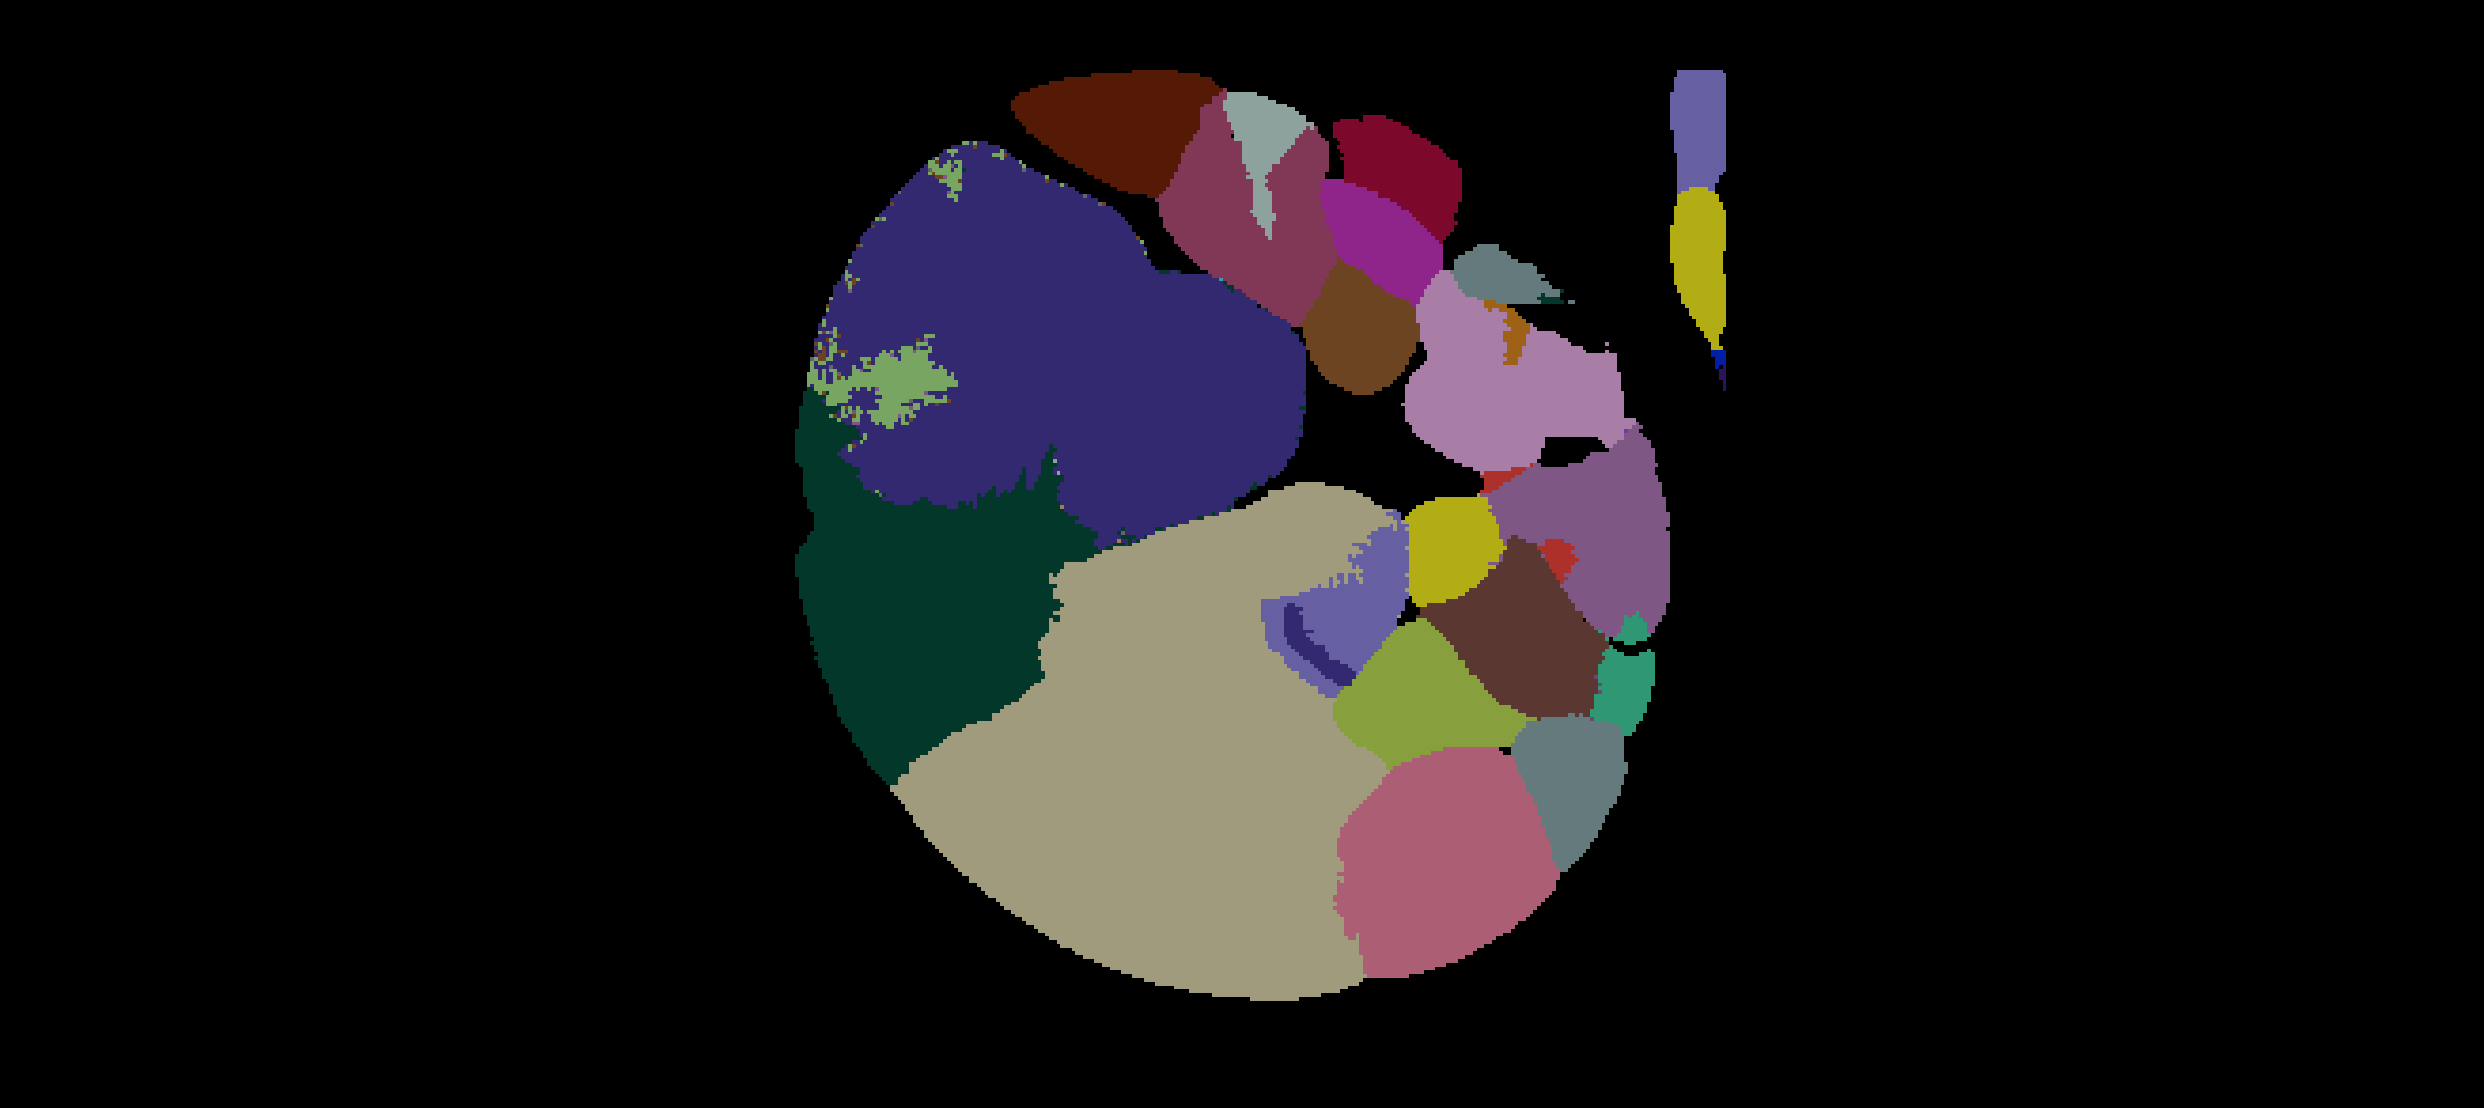

In [4]:
from napari.utils.notebook_display import nbscreenshot
viewer.add_labels(all_masks, name='all_masks')
nbscreenshot(viewer, canvas_only=True)

### Isolate a single mask that looks nice to work with

mask shape is (98, 256, 256)


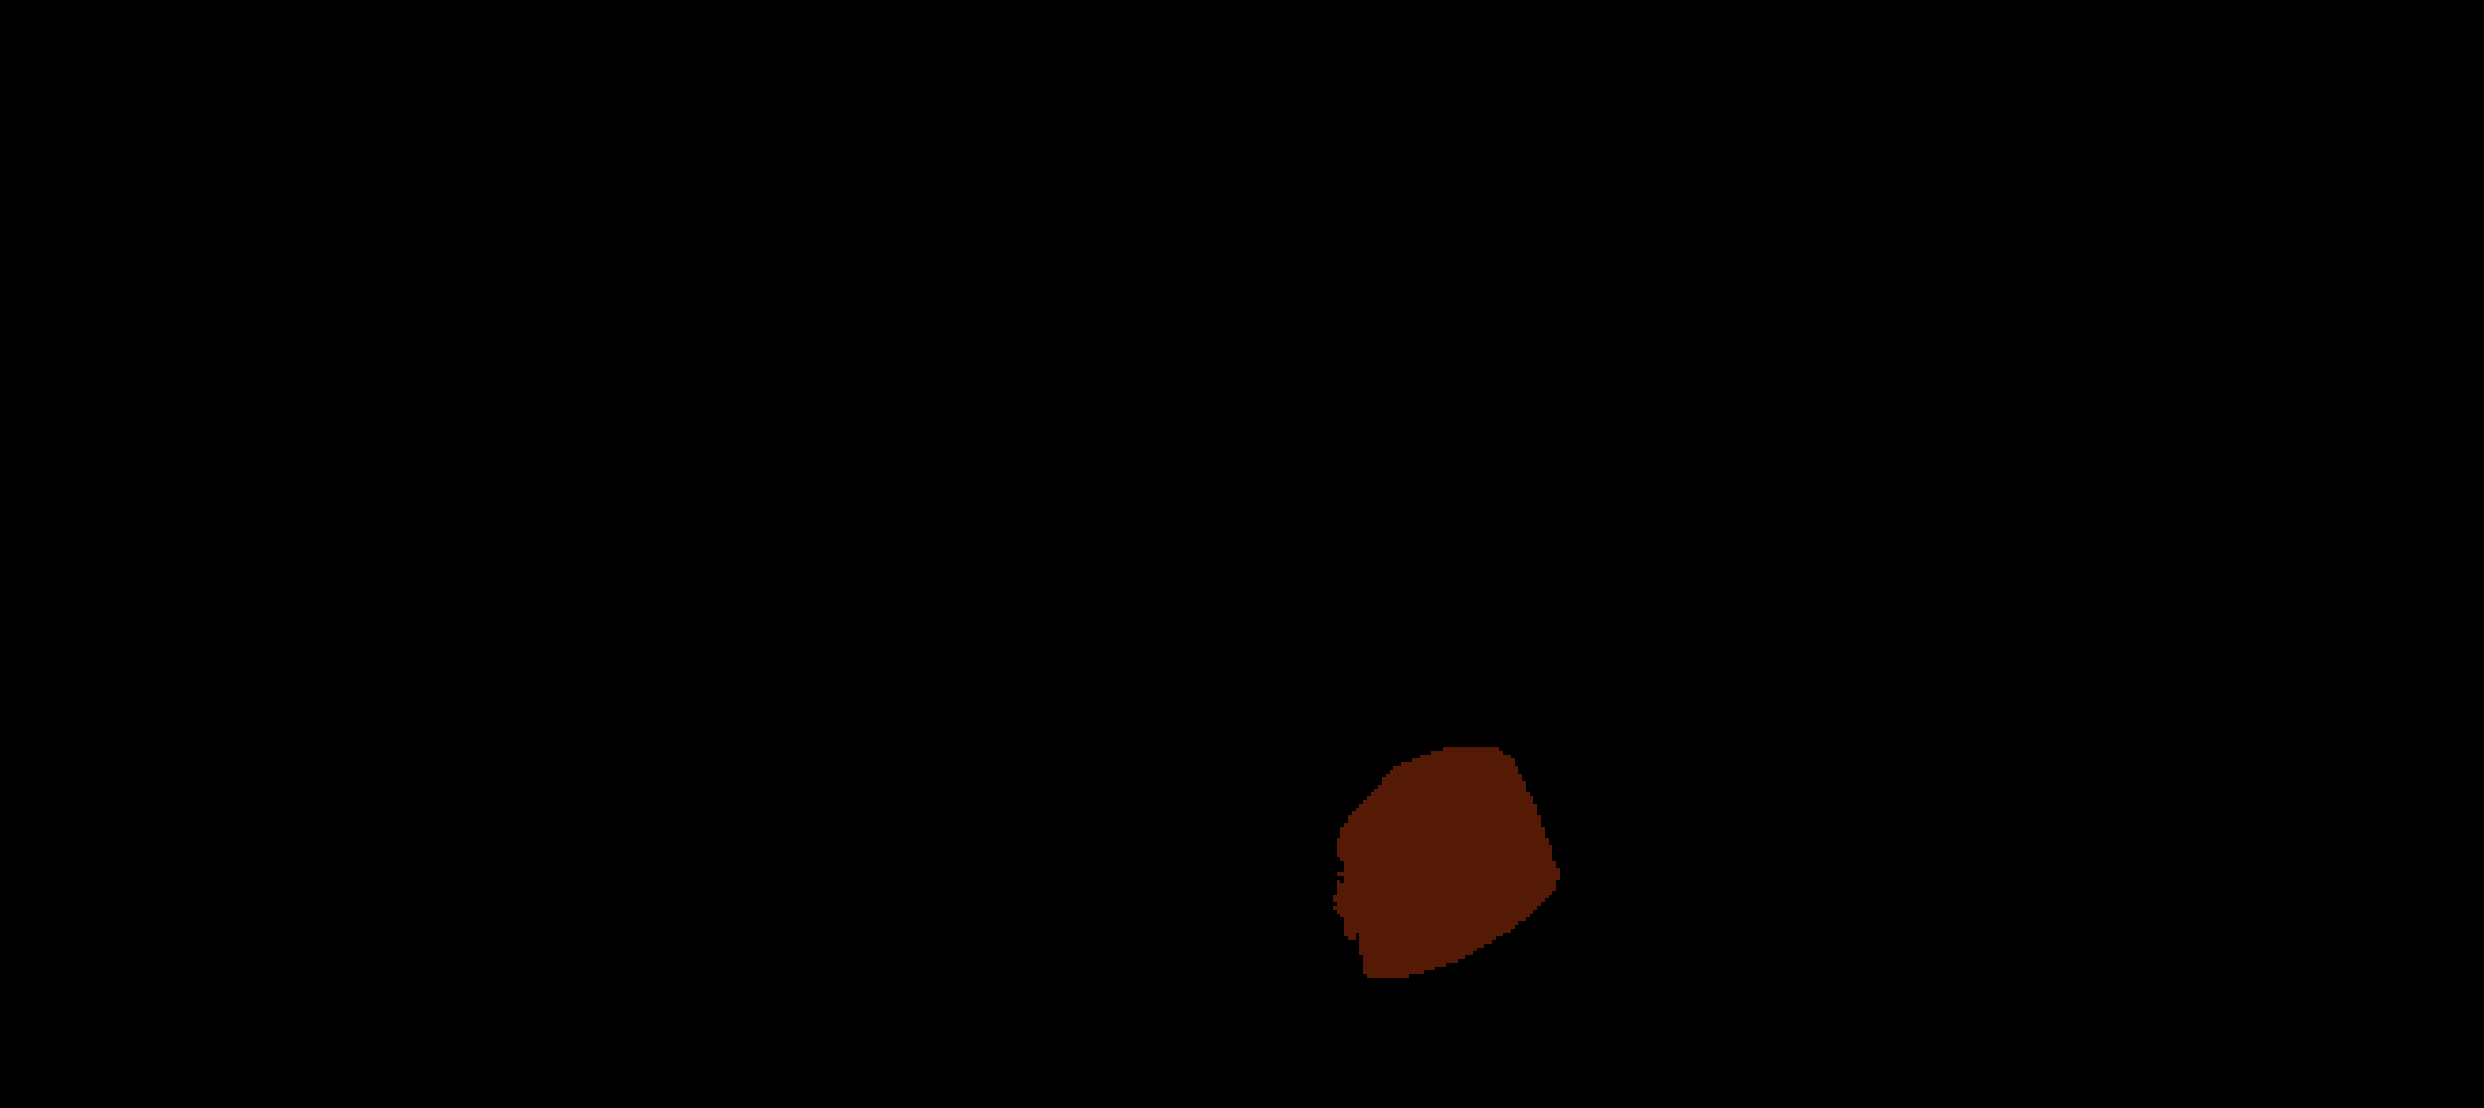

In [5]:
mask = all_masks == 82
print(f'mask shape is {mask.shape}')
viewer.add_labels(mask, name='mask')
nbscreenshot(viewer, canvas_only=True)

### Find the centroid of the mask

#### Solution #1
Use np.where to find the indices of the mask. Then calculate the mean or median of the distribution for each dimension. Add this location as a point.

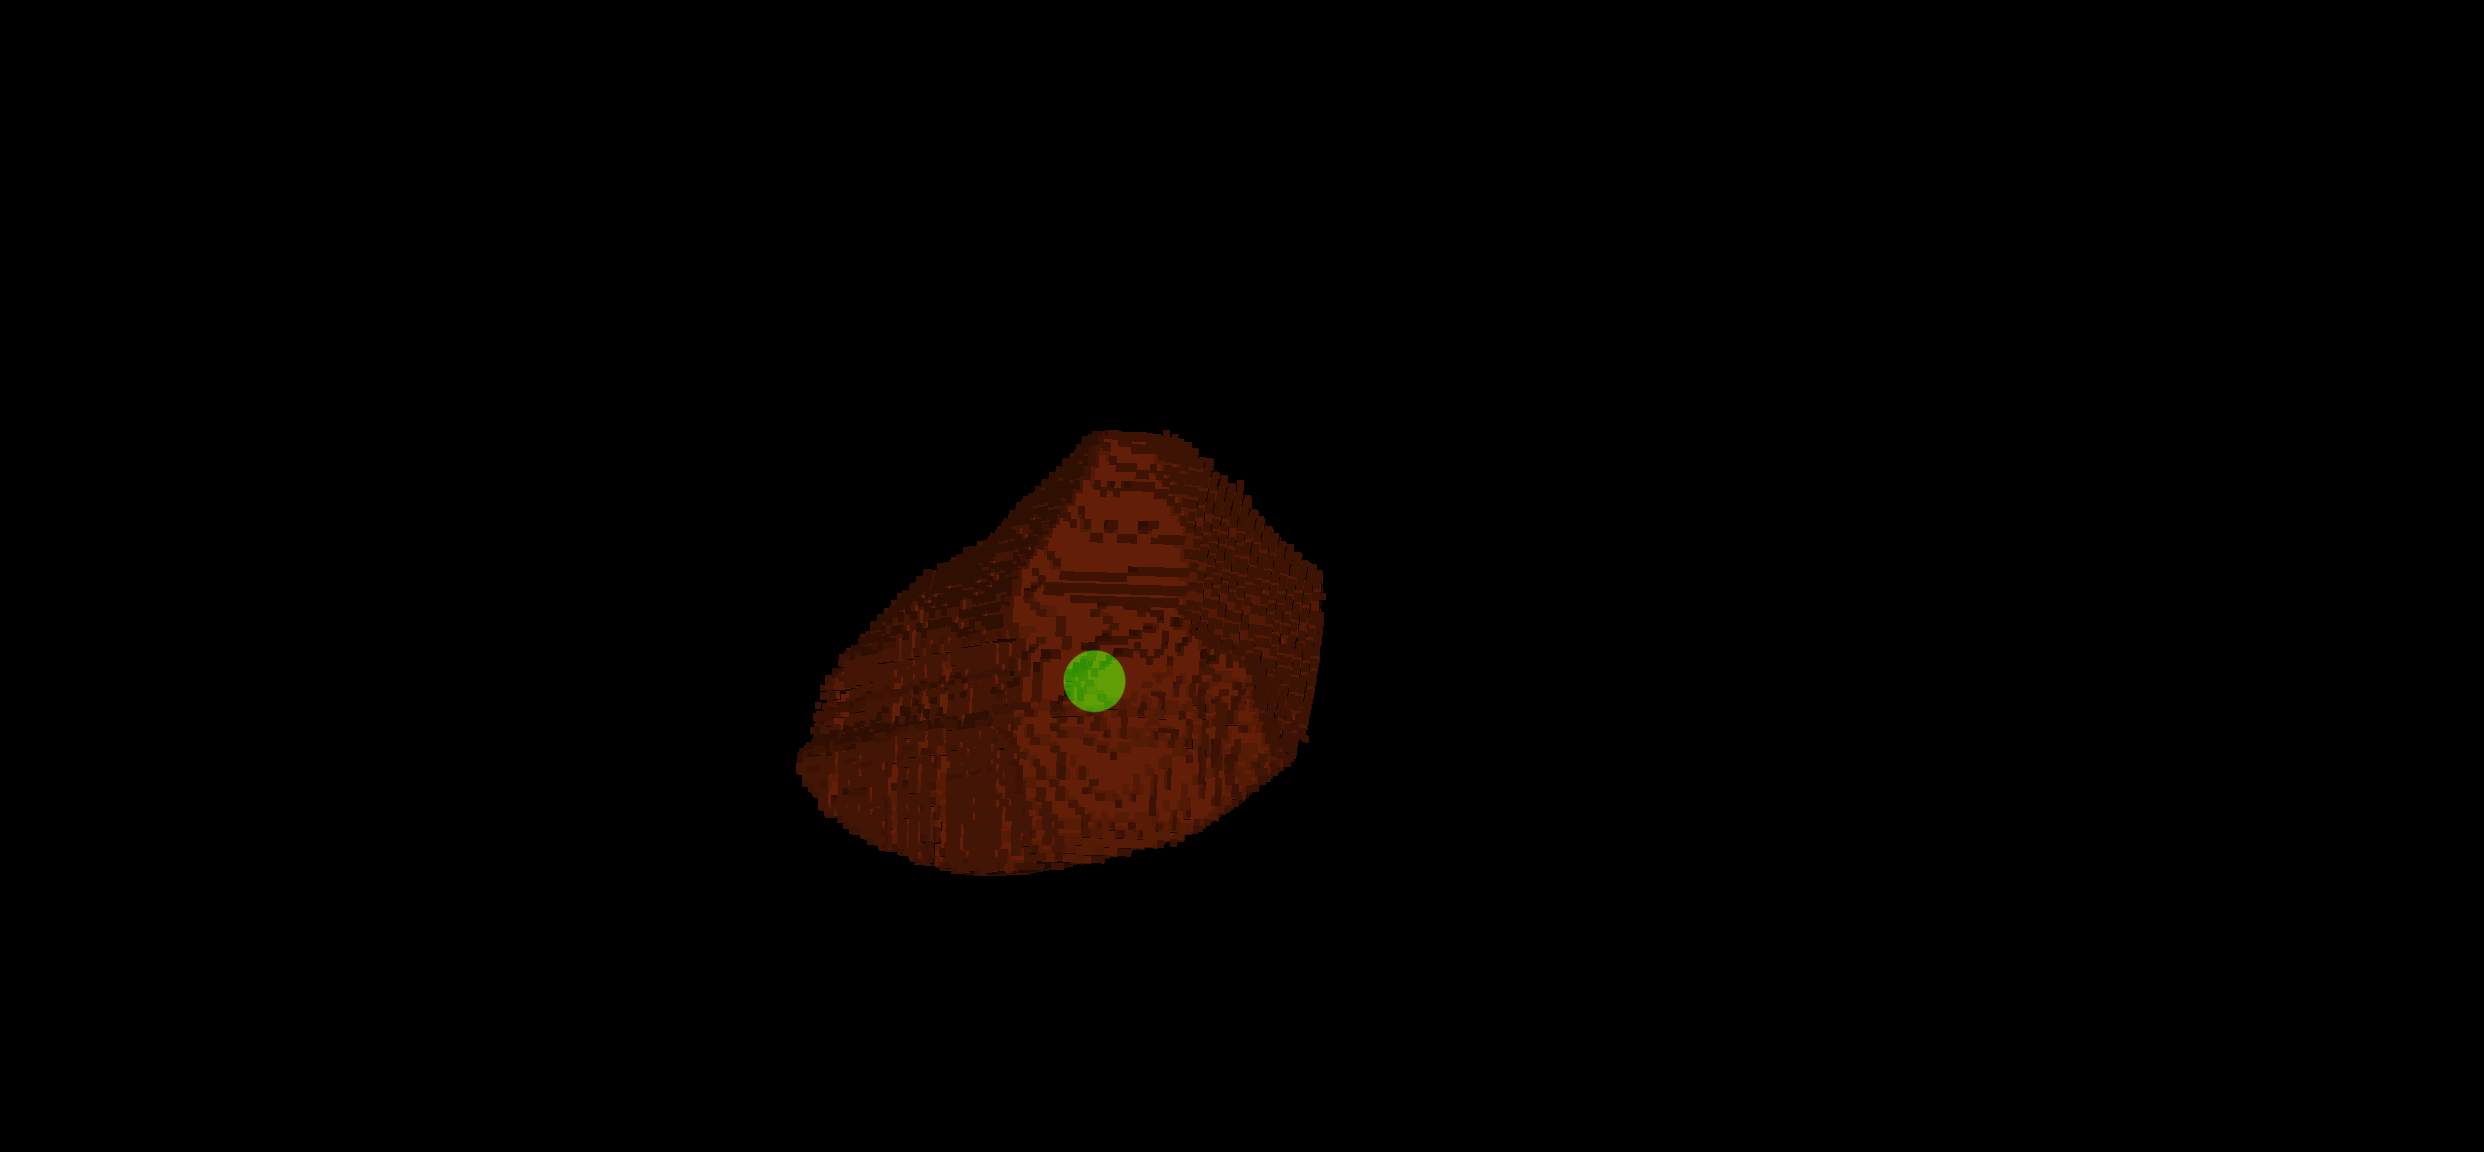

In [7]:
coords = np.where(mask == True)
z = np.median(coords[0])
y = np.median(coords[1])
x = np.median(coords[2])
viewer.add_points([(z,y,x)], name='centroid', face_color='green', blending='additive')
nbscreenshot(viewer, canvas_only=True)

#### Solution #2
Use vectorized solution from numpy_indexed (https://stackoverflow.com/questions/36955185/find-center-coordinates-of-regions-in-a-3d-numpy-array) to find either the mean or the median of the mask

In [13]:
import numpy_indexed as npi
idx = np.indices(mask.shape).reshape(mask.ndim, mask.size)
print(f'idx shape is {idx.shape}')
label, mean = npi.group_by(mask, axis=None).mean(idx, axis=1)
viewer.add_points(mean[:0], name='background', blending='additive')
viewer.add_points(mean[:,-1], name='centroid', face_color='green', blending='additive')
nbscreenshot(viewer, canvas_only=True)
print(mean[:,-1])

idx shape is (3, 6422528)
[ 50.71935261 209.35936057 178.09847626]


[[ 48.47005159 126.39537274 126.81721363]
 [ 50.71935261 209.35936057 178.09847626]]


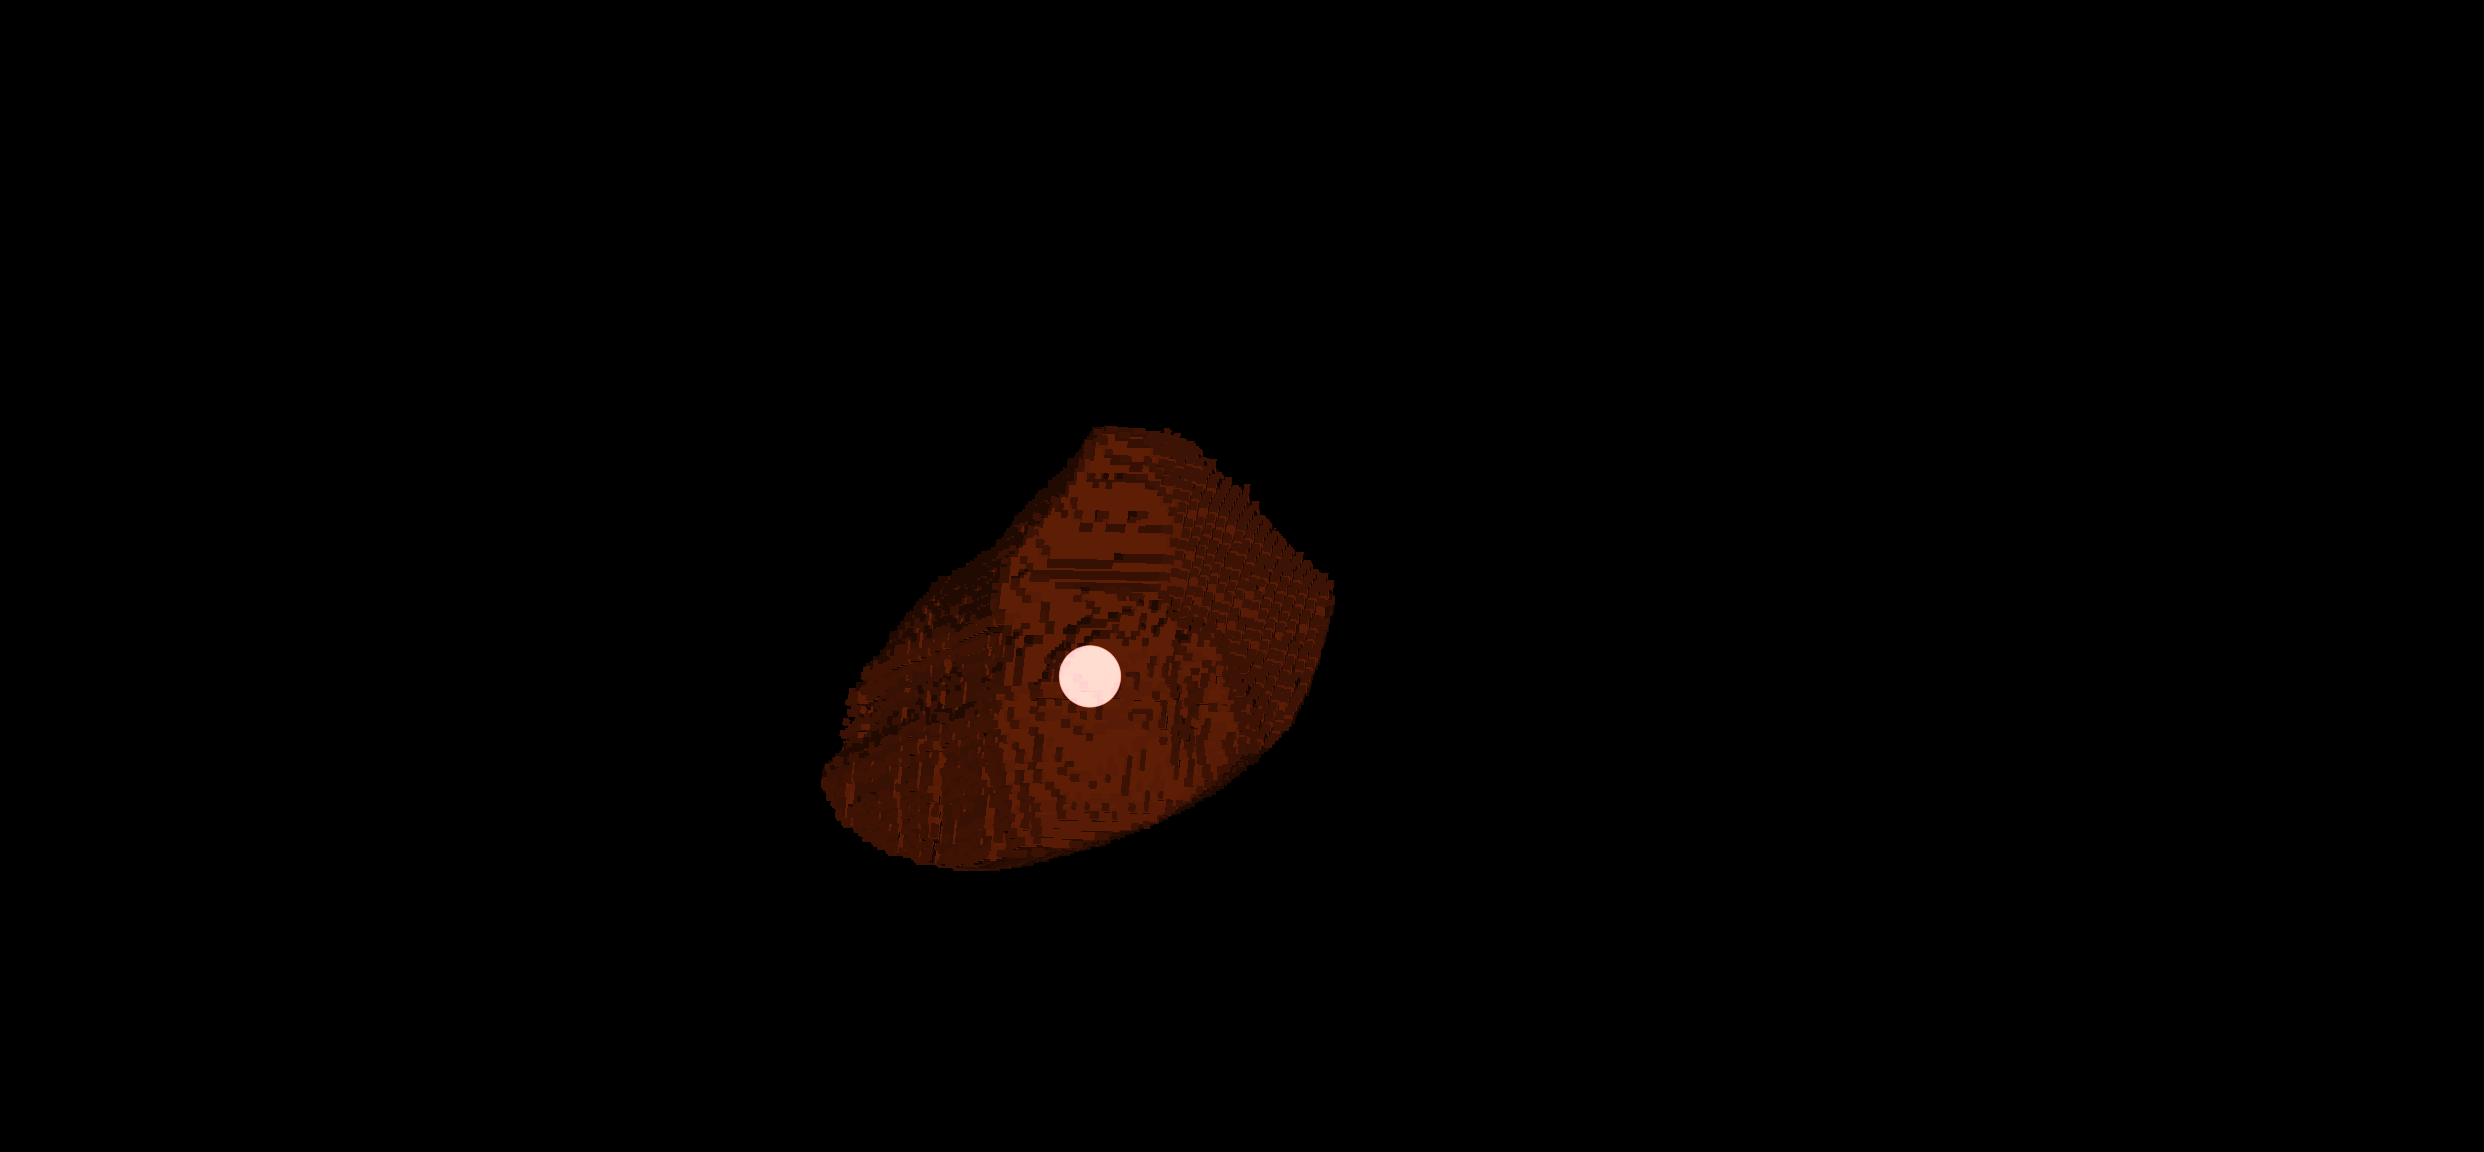

In [18]:
from sklearn.cluster import KMeans

X = np.column_stack((mean[0], mean[1], mean[2]))

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.cluster_centers_)
viewer.add_points(kmeans.cluster_centers_[1], name='k-means_centroid', face_color='pink', blending='additive')
nbscreenshot(viewer, canvas_only=True)

## Filter the cell masks of small shitty regions

In [37]:
viewer.add_labels(all_masks, name='all_masks')

<Labels layer 'all_masks' at 0x7fc8d97c1160>

In [20]:
def wipe_layers():
    layers = viewer.layers
    while len(layers) > 0:
        layers.remove(layers[0])

In [ ]:
def remove_large_objects(labels_array: np.ndarray):
    out = np.copy(labels_array)
    component_sizes = np.bincount(labels_array.ravel()) # count the number of different labels(?)
    too_big = component_sizes < min_size !!!
    too_small_mask = too_small[segments]
    out[too_small_mask] = 0
    return out

In [36]:
from skimage import morphology

# remove small objects
filtered_masks = morphology.remove_small_objects(all_masks, min_size=15000, connectivity=1)
wipe_layers()
viewer.add_labels(filtered_masks, name='filtered_masks')


<Labels layer 'filtered_masks' at 0x7fc8982ebee0>